# Part 2: Spotify Project

Author: Cristobal Zamorano Astudillo

## Introduction & Recap on Part 1

Previouly, in Part 1, we tried to handed a dataset without explicit instructions on what to do with it. Our dataset was a collection of metrics that Spotify uses for their music streaming platforms. Without a specific desired outcome, we attempted to automatically find structutre in the data by extracting useful features and analyzing its structure.

In order to understand and organize the data we used the Principal Component Analysis. Using this Dimensional Reduction algorithm, we found interesting things:
- Using the Covaraince Matrix we realized that the Time Feature Extractions that we did in EDA prior to PCA, were carrying too much correlation within similar Time features. So, we drop them for PCA purposes.
- After running our PCA algorithm, we found that the Liked Music and No-Liked music are way too similar in terms of modeling without a supervision. This means that cross-prediction of True-False and False-True results are very likely to happen without a test dataset to comparer themselves.
- Also, we found that some features are certainly more important than others therefore we can later on compare the features importance of PCA with other algortihms

##### Now what?

PCA stands for Principal Component "Analysis". As it is mentioned in its name, this algorithm aimes on better understanding the data set and its features. Nevertheless, one can use the resulted data set in lower dimensions for the classification with no problem.

While using PCA, be aware of the effects of the high variance features on the results. This feature or features may have no information on them and may mislead you and your classifier to nowhere. Imagine the noise in the data (signal noise) that will come up as the most important feature by PCA but, actually, it is worthless. 

Therefore, **the goal of this Part 2** is to compare classification algorithms with and without dimensionality reduction.

In [1]:
# Data Manipulation 
import pandas as pd

# Linear Algebra and Math
import numpy as np
from scipy import interp
import math
from scipy.stats import norm
from scipy import stats

# 2D Visualizations
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib.ticker import MaxNLocator



# 3D Visualizations
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
from plotly.offline import iplot
import plotly as py

# Decisiton Tree
import pydotplus
import io
import graphviz
from scipy import misc
import imageio

# from matplotlib.colors import DivergingNorm

%matplotlib inline

In [2]:
# I'm a big fan of  https://fivethirtyeight.com/ and their visualizations :) 
style.use('fivethirtyeight') 
# grid: rgb(240,240,240)
# background: rgb(200,200,200)

In [3]:
my_songs_df = pd.read_csv("./output/project_data/my_songs_clean.csv")
my_songs_df.drop(columns=["Unnamed: 0"], inplace = True)
display(my_songs_df.shape)
my_songs_df.head()

(19840, 31)

,song_name,endTime,artist,msPlayed,danceability,energy,key,loudness,mode,speechiness,...,Year,Week_of_Year,Day_of_Year,Quarter,Season,Season_Numeric,Day_Numeric,exists,liked,Listen_Count
0,La La Latch,2020-02-07 14:12,Pentatonix,189852,0.694,0.512,6,-8.719,0,0.0451,...,2020,6,38,1,Winter,1,5,True,1,2.0
1,Lejos De Ti,2020-02-07 14:14,Shamanes Crew,111980,0.666,0.725,9,-6.114,1,0.0405,...,2020,6,38,1,Winter,1,5,True,1,2.0
2,Perdón,2020-02-07 14:18,Mike Bahía,195554,0.666,0.817,9,-5.754,0,0.0369,...,2020,6,38,1,Winter,1,5,True,1,1.0
3,Dos Mundos,2020-02-07 14:21,Reyno,183789,0.634,0.520,5,-9.804,1,0.0479,...,2020,6,38,1,Winter,1,5,True,1,3.0
4,アウトサイダー,2020-02-07 14:25,SymaG,207600,0.526,0.885,6,-2.189,0,0.0654,...,2020,6,38,1,Winter,1,5,True,1,2.0


In [4]:
# Missing values
def missing_values_func(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
            columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    
        # Returns
        if mis_val_table_ren_columns.empty:
            return f'Your selected dataframe has  {df.shape[1]} features. There are  {mis_val_table_ren_columns.shape[0]} features that have missing values.'
        else:
            display(mis_val_table_ren_columns.style.background_gradient(cmap='Reds'))
            return f'Your selected dataframe has  {df.shape[1]} features. There are  {mis_val_table_ren_columns.shape[0]} features that have missing values.'
        
missing_values_func(my_songs_df)

,Missing Values,% of Total Values
Listen_Count,16894,85.2


'Your selected dataframe has  31 features. There are  1 features that have missing values.'

In [5]:
def my_pca(my_songs_df, pcs_displayed):
    # Select the features and avoid the "Time" features
    metrics = my_songs_df[[
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms',
       'time_signature']].reset_index(drop=True)
    feature_names = np.array(metrics.columns)
    # Step 1 - Standarize
    mean_metrics = np.mean(metrics, axis=0)
    sd_metrics = np.std(metrics, axis = 0)
    metrics_std = (metrics - mean_metrics) / sd_metrics 
    # Step 2 - Covariance Matrix
    mean_vec = np.mean(metrics_std, axis=0)
    cov_mat = (metrics_std - mean_vec).T.dot((metrics_std - mean_vec)) / (metrics_std.shape[0]-1)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    
    #Step 3 - Sort Eigenvalues
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()

    # Visually confirm that the list is correctly sorted by decreasing eigenvalues
    print(f'\nEigenvalues in descending order:\n')
    for i in eig_pairs:
        print(i[0])
    # Step 4 - Projection Matrix
    for i in range(0,pcs_displayed - 1):
        matrix_w = np.hstack(([eig_pairs[i][1].reshape(metrics.shape[1],1) for i in range(0,pcs_displayed)]))
    
    Y = metrics_std.values.dot(matrix_w)
    scores_df = pd.DataFrame(data= Y, columns=['PC%s' %(i + 1) for i in range(0,pcs_displayed)])
    features_pc_df = pd.DataFrame(matrix_w, columns=['PC%s' %(i + 1) for i in range(0,pcs_displayed)], index=feature_names)
    
    return scores_df, features_df

In [6]:
features_scores_df = pd.read_csv('./output/project_data/pca/features_metrics_spotify.csv')
features_scores_df.set_index('Unnamed: 0', inplace = True)
features_scores_df.index.rename(None, inplace = True)
display(features_scores_df.shape)
display(missing_values_func(features_scores_df))
features_scores_df.head()

(13, 7)

'Your selected dataframe has  7 features. There are  0 features that have missing values.'

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
danceability,-0.176942,0.562844,-0.349095,0.043449,0.095070,0.295942,0.051013
energy,-0.464740,-0.231684,0.015233,-0.002897,-0.036371,-0.062290,-0.072609
key,-0.038121,0.171593,0.222539,-0.386803,-0.654764,0.166608,0.456210
loudness,-0.474893,-0.006879,-0.037392,0.040549,-0.040171,-0.089642,0.037344
mode,0.018005,-0.096202,-0.170968,0.750689,-0.031638,-0.101861,0.489776


In [7]:
songs_projections_df = pd.read_csv('./output/project_data/pca/eigenvectors_liked_dislike_music.csv')
songs_projections_df.set_index('Unnamed: 0', inplace = True)
songs_projections_df.index.rename(None, inplace = True)
songs_projections_df.drop(columns=["Type_of_Song"], inplace = True)
display(songs_projections_df.shape)
display(missing_values_func(songs_projections_df))
songs_projections_df.head()

(19840, 7)

'Your selected dataframe has  7 features. There are  0 features that have missing values.'

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0.130571,0.331147,-0.325464,-1.183208,-0.137404,-0.071711,-0.340805
1,-0.428393,0.483243,-1.471697,-0.036634,-0.875166,0.409169,1.072726
2,-0.292930,0.044690,-0.360769,-1.030924,-1.461369,0.481620,-0.377420
3,1.028599,0.379275,-0.214344,0.705914,-0.114743,-0.814090,0.195682
4,-1.790149,0.024812,0.503433,-1.359785,0.336073,-0.703231,-0.162005


In [8]:
target = my_songs_df['liked']
# songs_projections_df.drop(columns=['Type_of_Song'], inplace=True)
# songs_projections_df.shape

In [9]:
weekly_df = pd.read_csv('./output/project_data/weekly_discover_final.csv')
weekly_df.set_index('Unnamed: 0', inplace = True)
weekly_df.index.rename(None, inplace = True)
display(weekly_df.shape)
display(missing_values_func(weekly_df))
display(weekly_df.head())
weekly_df.drop(columns = ['artist','album','song_name'], inplace = True)
display(weekly_df.shape)
weekly_df.head()

(180, 16)

'Your selected dataframe has  16 features. There are  0 features that have missing values.'

,artist,album,song_name,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,acousticness
0,Porta,Libérate,Libérate,0.755,0.808,7,-6.591,1,0.3790,0.00000,0.0816,0.525,92.262,182870,4,0.135000
1,Destripando la Historia,Hestia,Hestia,0.858,0.574,6,-5.931,1,0.0632,0.00000,0.3010,0.938,121.998,212828,4,0.460000
2,Brian the Sun,Lonely Go! (Another Edition),Lonely Go!,0.477,0.979,8,-1.650,1,0.0933,0.00000,0.3330,0.449,102.036,238507,4,0.000081
3,Say Ocean,Primer Lugar,Primer Lugar,0.668,0.942,10,-1.859,0,0.1340,0.00000,0.0955,0.813,147.997,212939,4,0.044000
4,Alvei,Summertime Trap Ver.,Summertime Trap Ver.,0.846,0.366,9,-8.304,1,0.1910,0.00257,0.0837,0.873,125.129,123115,4,0.028100


(180, 13)

,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,acousticness
0,0.755,0.808,7,-6.591,1,0.3790,0.00000,0.0816,0.525,92.262,182870,4,0.135000
1,0.858,0.574,6,-5.931,1,0.0632,0.00000,0.3010,0.938,121.998,212828,4,0.460000
2,0.477,0.979,8,-1.650,1,0.0933,0.00000,0.3330,0.449,102.036,238507,4,0.000081
3,0.668,0.942,10,-1.859,0,0.1340,0.00000,0.0955,0.813,147.997,212939,4,0.044000
4,0.846,0.366,9,-8.304,1,0.1910,0.00257,0.0837,0.873,125.129,123115,4,0.028100


## Machine Learning Model Building Process

There are mainly two types of learning algorithms: **Unsupervised vs Supervised**

#### Supervised Learning

Recall your time at school when you were a kid. Think of your teacher as the output variable that you want to predict. The teacher will teach the students, in other words **the output variable will be teaching the algortihm to learn how to classify the data objects based on the output variable**. 

The error will adjust the parameter until we have a predictive model that can accurately predict the output variable.


#### Unsupervised Learning

You don't have a teacher or an output variable. They are self-organizing data map such as PCA. For example, in Part 1 we purposely didn't have an outcome to use PCA so we can freely explore the dimensions and see if we could use the dataset for a machine learning modeling without output variable to teach the dataset. As it was explained before, we couldn't get that results because the difference between Liked and No-Liked songs are too hard to differentiate without a supervised output variable.

### Classification vs Regression

Your output variable will be suitable of classification or regression depending on whether the output variable is quantitiative or qualitative value.

- If Quantitatiive or numeric output variable: **Use Regression**
- If Qualitative or categorical label output variable: **Use Classification**

Classification type can be **binary or multiclass**.

For this Spotify project, we previously constructed the `liked` feature, which is a feature of 1s (song added to the liked song playlist) and 0s (no added to the liked songs playlist). Thus, from now on we will be working on a **Supervised Classification Model**. We will be identifying which category a song should belong to using an testing dataset to compare to.

The testing dataset will be the "Weekly Playlist" from Spotify. We will be comparing the classification model using the Spotify features against their own weekly recomendation playlist.


### Splitting Data

The training data we downloaded is all the data we have available for both training models and validating the models that we train. We therefore need to split the training data into separate training and validation datsets. You will need this validation data to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every song.

#### Training set

We have the trained model and the cross-validated model.

In the Cross-validation model we will separate the dataset of the training set into $k$ number of folds, where a $k$ fold means the number of times we separate or partition the data. Each partition will have the roughly the same number of data samples. 

For example, if you have $150$ Iris flowers, then having a $10$ fold cross validation each fold will contain $15$ flowers. So, $15$ random flowers will be assigned to each of the ten partitions. In one iteration one partition will be left out and the remaining $9$ partition will be used to create the partition model.. and then the prediction model will be applied to the left out partition and so that concludes iteration one. Then the next iteration will then take the left out partition and move it back in and take a new partition out in order to use the remaining $9$ to create a prediction model and the apply the prediction model to predict the values of the left out partition. We do this over and over until each partition will be left out at least one time and then the prediction accuracy will be average of the $k$s iterations.

In the Trained model we use it to predict the y-values of the training sets and also the test sets


In [10]:
import warnings
warnings.filterwarnings(action='ignore')

## Classification Models

Machine learning models learn from data. It is crucial, however, that the data you feed them is specifically preprocessed and refined for the problem you want to solve. This includes data cleaning, preprocessing, feature engineering, and so on.

Very often, when presented with a dataset, I would fire up a Jupyter notebook and start exploring it interactively. The notebook is great for that task, but after a while I ended up with code that is a total mess in the global namespace

Therefore, we will be using the [Scikit-learn: Machine Learning in Python](https://scikit-learn.org/stable/), an open-source and efficient set of tools for predictive data analysis. Most of the algorithms will be imported from here.

We wil be also using [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/), two gradient boosting library. A gradient boosting is a machine learning technique used in either regression or classification modeling. It is specially helpful when dealing with weak learning models.

In addition, 

In [11]:
# Importing packages for modelling.

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, cross_validate, train_test_split, KFold
# from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

import xgboost as xgb
import lightgbm as lgb
from mlxtend.plotting import plot_decision_regions

In [12]:
metrics = my_songs_df[[
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms',
       'time_signature']].reset_index(drop=True)
X = metrics
y = target
X_test= weekly_df

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'X_test shape: {X_test.shape}')

X shape: (19840, 13)
y shape: (19840,)
X_test shape: (180, 13)


In [13]:
cv = StratifiedKFold(10, shuffle=True, random_state=42)

rf = RandomForestClassifier(criterion='gini',
                            n_estimators=1750,
                            max_depth=7,
                            min_samples_split=6,
                            min_samples_leaf=6,
                            max_features='auto',
                            oob_score=True,
                            random_state=42,
                            n_jobs=-1,
                            verbose=0)

lg = lgb.LGBMClassifier(max_bin=4,
                        num_iterations=550,
                        learning_rate=0.0114,
                        max_depth=3,
                        num_leaves=7,
                        colsample_bytree=0.35,
                        random_state=42,
                        n_jobs=-1)

xg = xgb.XGBClassifier(
    n_estimators=2800,
    min_child_weight=0.1,
    learning_rate=0.002,
    max_depth=2,
    subsample=0.47,
    colsample_bytree=0.35,
    gamma=0.4,
    reg_lambda=0.4,
    random_state=42,
    n_jobs=-1,
)

# sv = SVC(probability=True)

logreg = LogisticRegression(n_jobs=-1, solver='newton-cg')

gb = GradientBoostingClassifier(random_state=42)

gnb = GaussianNB()

mlp = MLPClassifier(random_state=42)

In [14]:
estimators = [
    rf, 
    lg,
    xg,
    gb,
    logreg
]

In [15]:
def model_check_accuracy(X, y, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est in estimators:
        model_table.loc[row_index, 'Model Name'] = est.__class__.__name__
        cv_results = cross_validate(
            est,
            X,
            y,
            cv=cv,
            scoring='accuracy',
            return_train_score=True,
            n_jobs=-1
        )

        model_table.loc[row_index, 'Train Accuracy Mean'] = cv_results[
            'train_score'].mean()
        model_table.loc[row_index, 'Test Accuracy Mean'] = cv_results[
            'test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test Accuracy Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

In [22]:
def model_check_f1(X, y, estimators, cv):
    model_table = pd.DataFrame()
    row_index = 0
    for est in estimators:
        model_table.loc[row_index, 'Model Name'] = est.__class__.__name__
        # Build Cross Validation
        cv_results = cross_validate(
            est,
            X,
            y,
            cv=cv,
            scoring='f1',
            return_train_score=True,
            n_jobs=-1
        )

        model_table.loc[row_index, 'Train Accuracy Mean'] = cv_results[
            'train_score'].mean()
        model_table.loc[row_index, 'Test Accuracy Mean'] = cv_results[
            'test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test Accuracy Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

In [16]:
# Plotting model performances
def model_barplot(models, bins):
    fig, ax = plt.subplots(figsize=(16, 8))
    g = sns.barplot('Test Accuracy Mean',
                    'Model Name',
                    data=models,
                    palette='plasma',
                    orient='h',
                    **{'xerr': models['Test Std']})
    g.set_xlabel('Test Mean Accuracy')
    g = g.set_title('Cross validation scores')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=bins))

In [17]:
from sklearn import metrics



def compare_roc_curves(estimators, cv, X, y):

    fig, axes = plt.subplots(math.ceil(len(estimators) / 2),
                             2,
                             figsize=(25, 50))
    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for i, (train, test) in enumerate(cv.split(X, y)):
            estimator.fit(X.loc[train], y.loc[train])
            viz = metrics.plot_roc_curve(estimator,
                                 X.loc[test],
                                 y.loc[test],
                                 name='ROC fold {}'.format(i),
                                 alpha=0.3,
                                 lw=1,
                                 ax=ax)
            interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        ax.plot([0, 1], [0, 1],
                linestyle='--',
                lw=2,
                color='r',
                label='Chance',
                alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr,
                mean_tpr,
                color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' %
                (mean_auc, std_auc),
                lw=2,
                alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr,
                        tprs_lower,
                        tprs_upper,
                        color='grey',
                        alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        ax.set(xlim=[-0.02, 1.02],
               ylim=[-0.02, 1.02],
               title=f'{estimator.__class__.__name__} ROC')
        ax.legend(loc='lower right', prop={'size': 18})
    plt.show()

In [26]:
def compare_learning_curves(estimators,
                        X,
                        y,
                        cv=None,
                        n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Returns subplots of Learning Curves for Classification Models.
    
    Paramaters
    -----------
    
    estimators : Machine Learning Models
    X          : Training Dataset
    y          : Target
    cv         : Cross Validation Folding Object
    n_jobs     :
    train_sizes: Sample size
    
    Colors
    ------
    
    Train : #e50914 (Netflix Red)
    Test  : #1DB954 (Spotify Green)
    
    """
    # Step 1 : Create Empty Subplot Containers
    # Rows are subplots based on the number of Models to Compare
    # Columns 2 per row
    fig, axes = plt.subplots(math.ceil(len(estimators) / 2), 2, figsize=(25, 50))
    axes = axes.flatten()
    # Iterate through the Model names
    for ax, estimator in zip(axes, estimators):
        # Set up Graph Labels and Title
        ax.set_title(f'{estimator.__class__.__name__} Learning Curve')
        ax.set_xlabel('Training examples')
        ax.set_ylabel('Score')
        #------------------------
        # Step 2 : Use the `learning_curve` method from Sckit-Learn. 
        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                                                                              train_sizes=train_sizes, return_times=True)
        # This returns the above outputs. We'll use these outputs to calculate how much the 
        # learning values fluctutate between train and test samples respectively
        # Normalize th evalues by obtaining the std and mean respectively. 
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        # Step 3 : Plot Training and Test learning curves
        # Training fluctuation
        ax.fill_between(train_sizes,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1,
                        color='#e50914')
        # Test Fluctuation
        ax.fill_between(train_sizes,
                        test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std,
                        alpha=0.1,
                        color='#1DB954')
        # Plot Train Scores
        ax.plot(train_sizes,
                train_scores_mean,
                'o-',
                color='#e50914',
                label='Training score')
        # Plot Test Scores
        ax.plot(train_sizes,
                test_scores_mean,
                'o-',
                color='#1DB954',
                label='Cross-validation score')
        ax.legend(loc='best')
        ax.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.show()

In [28]:
def compare_feature_importance(estimators, X, y, bins):
    """
    Returns subplots of barplots ranking the feature Importance of each Model.
    
    Paramaters
    -----------
    
    estimators : Machine Learning Models
    X          : Training Dataset
    y          : Target
    bins       : Number of Audio Features that we interested ranking
    
    """
    # Step 1 : Create Empty Subplot Containers
    # Rows are subplots based on the number of Models to Compare
    # Columns 2 per row
    fig, axes = plt.subplots(math.ceil(len(estimators) / 2), 2, figsize=(20, 14))
    axes = axes.flatten()
    # Iterate through each Model
    for ax, estimator in zip(axes, estimators):
        # Catch an exception if it occurs with continue
        try:
            estimator.fit(X, y)
            feature_imp = pd.DataFrame(sorted(
                zip(estimator.feature_importances_, X.columns)),
                                       columns=['Value', 'Feature'])

            sns.barplot(x="Value",
                        y="Feature",
                        data=feature_imp.sort_values(by="Value",
                                                     ascending=False),
                        ax=ax,
                        palette='plasma')
            plt.title('Features')
            plt.tight_layout()
            ax.set(title=f'{estimator.__class__.__name__} Feature Importances')
            ax.xaxis.set_major_locator(MaxNLocator(nbins=bins))
        except:
            continue
    plt.show()

****
### Run algorithms

In [20]:
raw_models = model_check_accuracy(X, y, estimators, cv)
display(raw_models.style.background_gradient(cmap='summer_r'))

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Test Std,Time
3,GradientBoostingClassifier,0.88274,0.875151,0.00854792,3.89923
0,RandomForestClassifier,0.851417,0.846724,0.00931697,36.9374
2,XGBClassifier,0.824076,0.823538,0.00955656,23.4888
1,LGBMClassifier,0.803971,0.802722,0.00843769,0.892943
4,LogisticRegression,0.784655,0.784577,0.00923961,1.84042


In [21]:
pca_models = model_check(songs_projections_df, y, estimators, cv)
display(pca_models.style.background_gradient(cmap='summer_r'))

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Test Std,Time
3,GradientBoostingClassifier,0.876506,0.871976,0.00947259,2.90728
0,RandomForestClassifier,0.850325,0.845161,0.0107698,35.4883
2,XGBClassifier,0.799177,0.797984,0.00670874,17.6345
4,LogisticRegression,0.767787,0.767389,0.00973513,0.109607
1,LGBMClassifier,0.767742,0.766885,0.00824289,0.729452


### F1 Scores

In [23]:
# F1 Benchmark
raw_models_f1 = model_check_f1(X, y, estimators, cv)
display(raw_models.style.background_gradient(cmap='inferno_r'))

,Model Name,Train Accuracy Mean,Test Accuracy Mean,Test Std,Time
3,GradientBoostingClassifier,0.91873,0.913711,0.0056051,3.71393
0,RandomForestClassifier,0.900244,0.897301,0.00576604,34.0204
2,XGBClassifier,0.882547,0.882245,0.00590162,21.8999
1,LGBMClassifier,0.869219,0.868454,0.00516838,0.811924
4,LogisticRegression,0.857835,0.857797,0.0058885,1.86951


#### Model General Performances

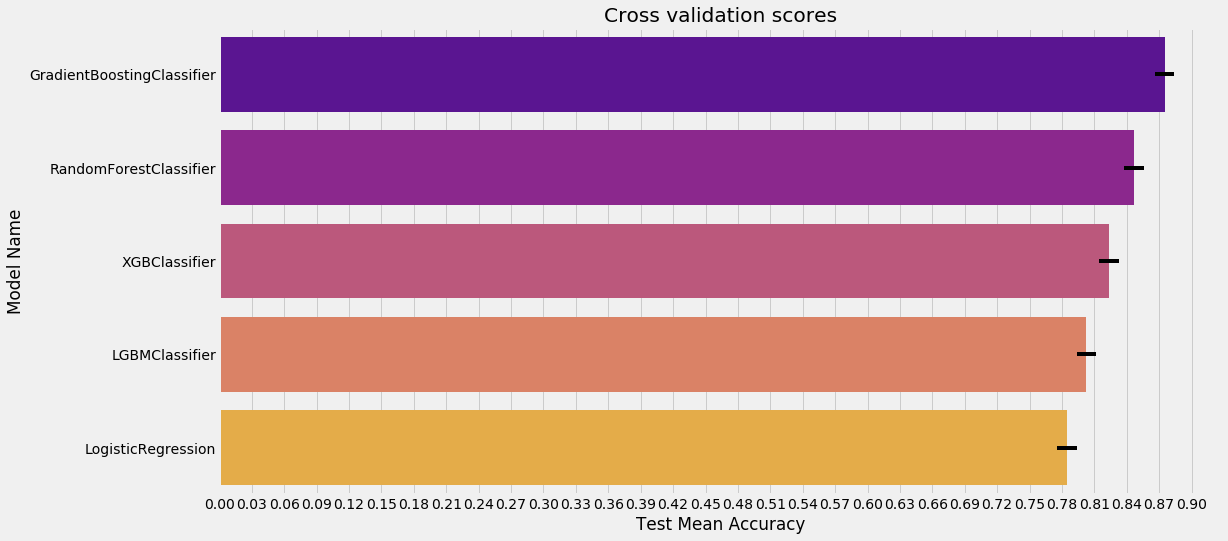

In [22]:
# Plotting model performances
model_barplot(raw_models, 32)

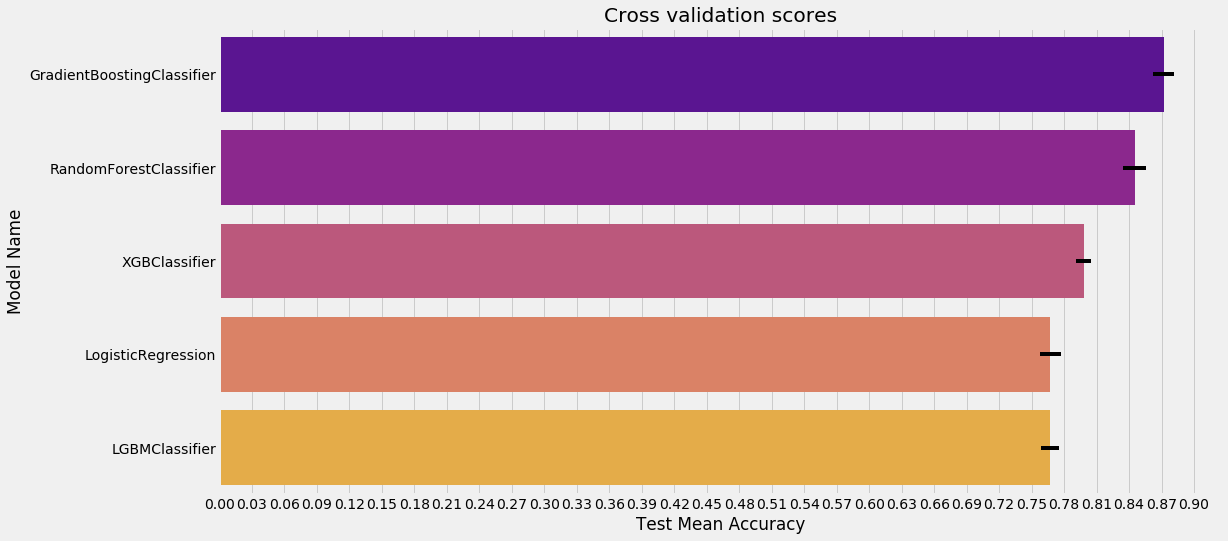

In [23]:
# Plotting model performances
model_barplot(pca_models, 32)

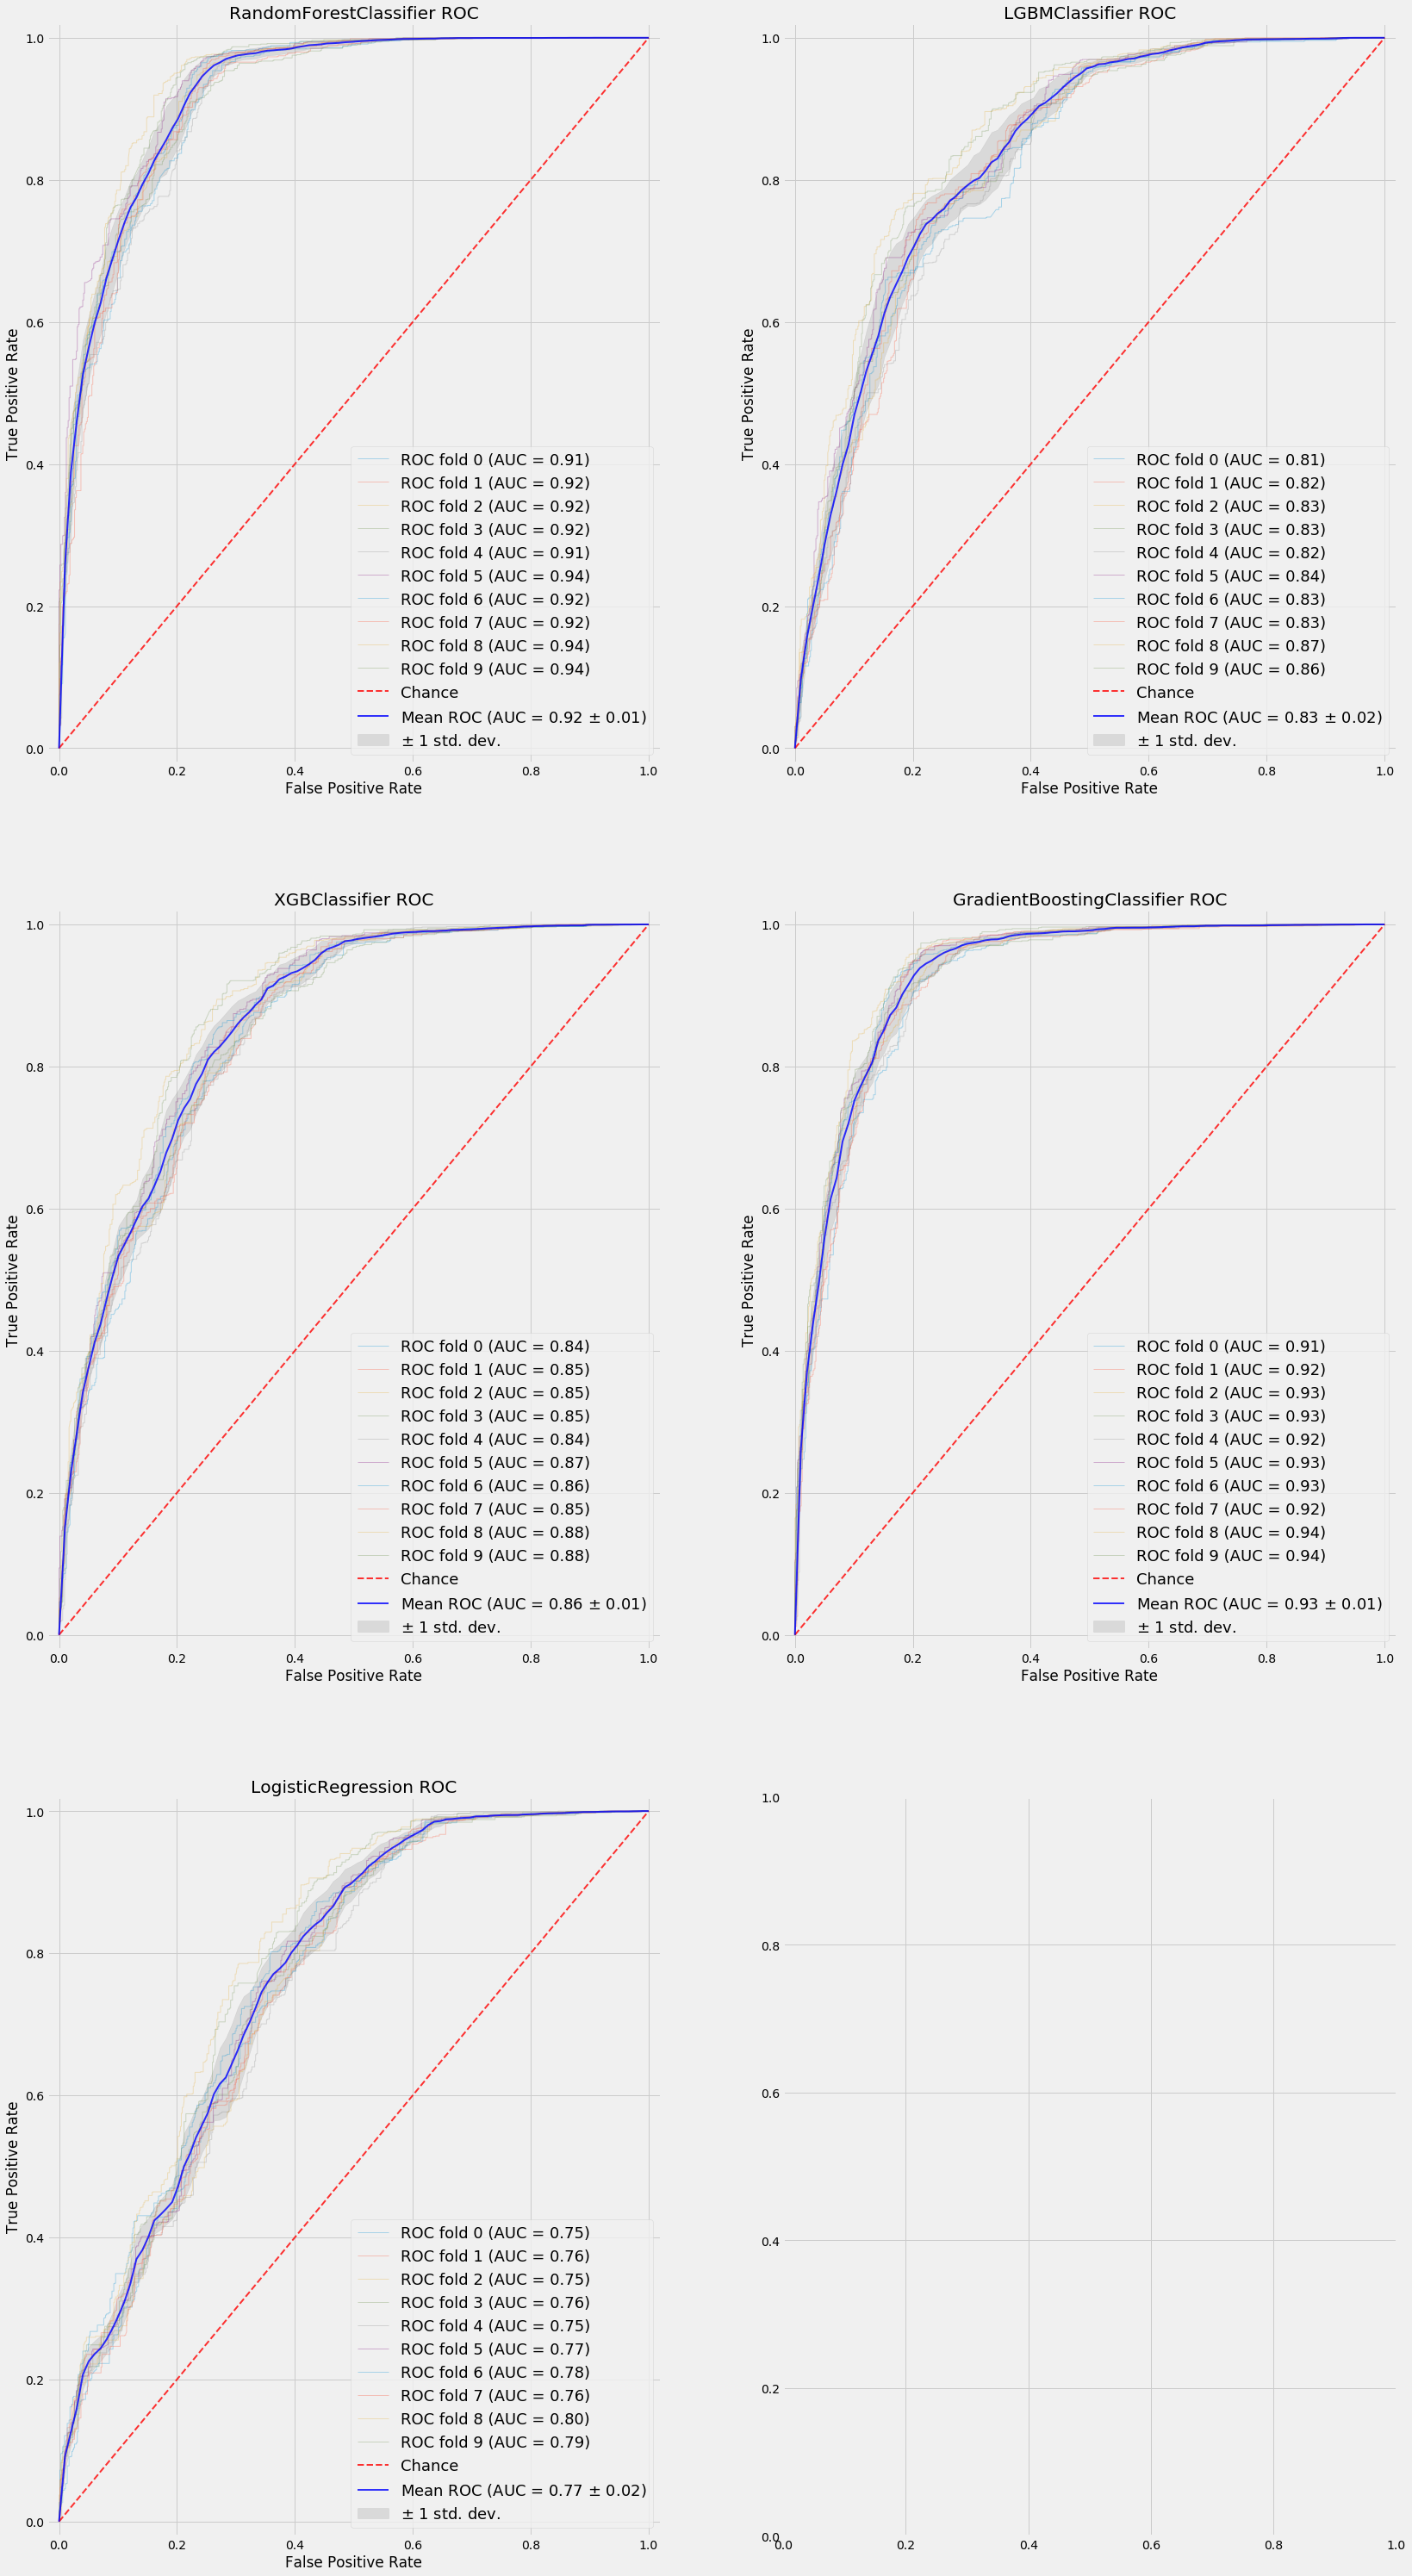

In [24]:
compare_roc_curves(estimators, cv, X, y)

### Compare Models' Learning Curves

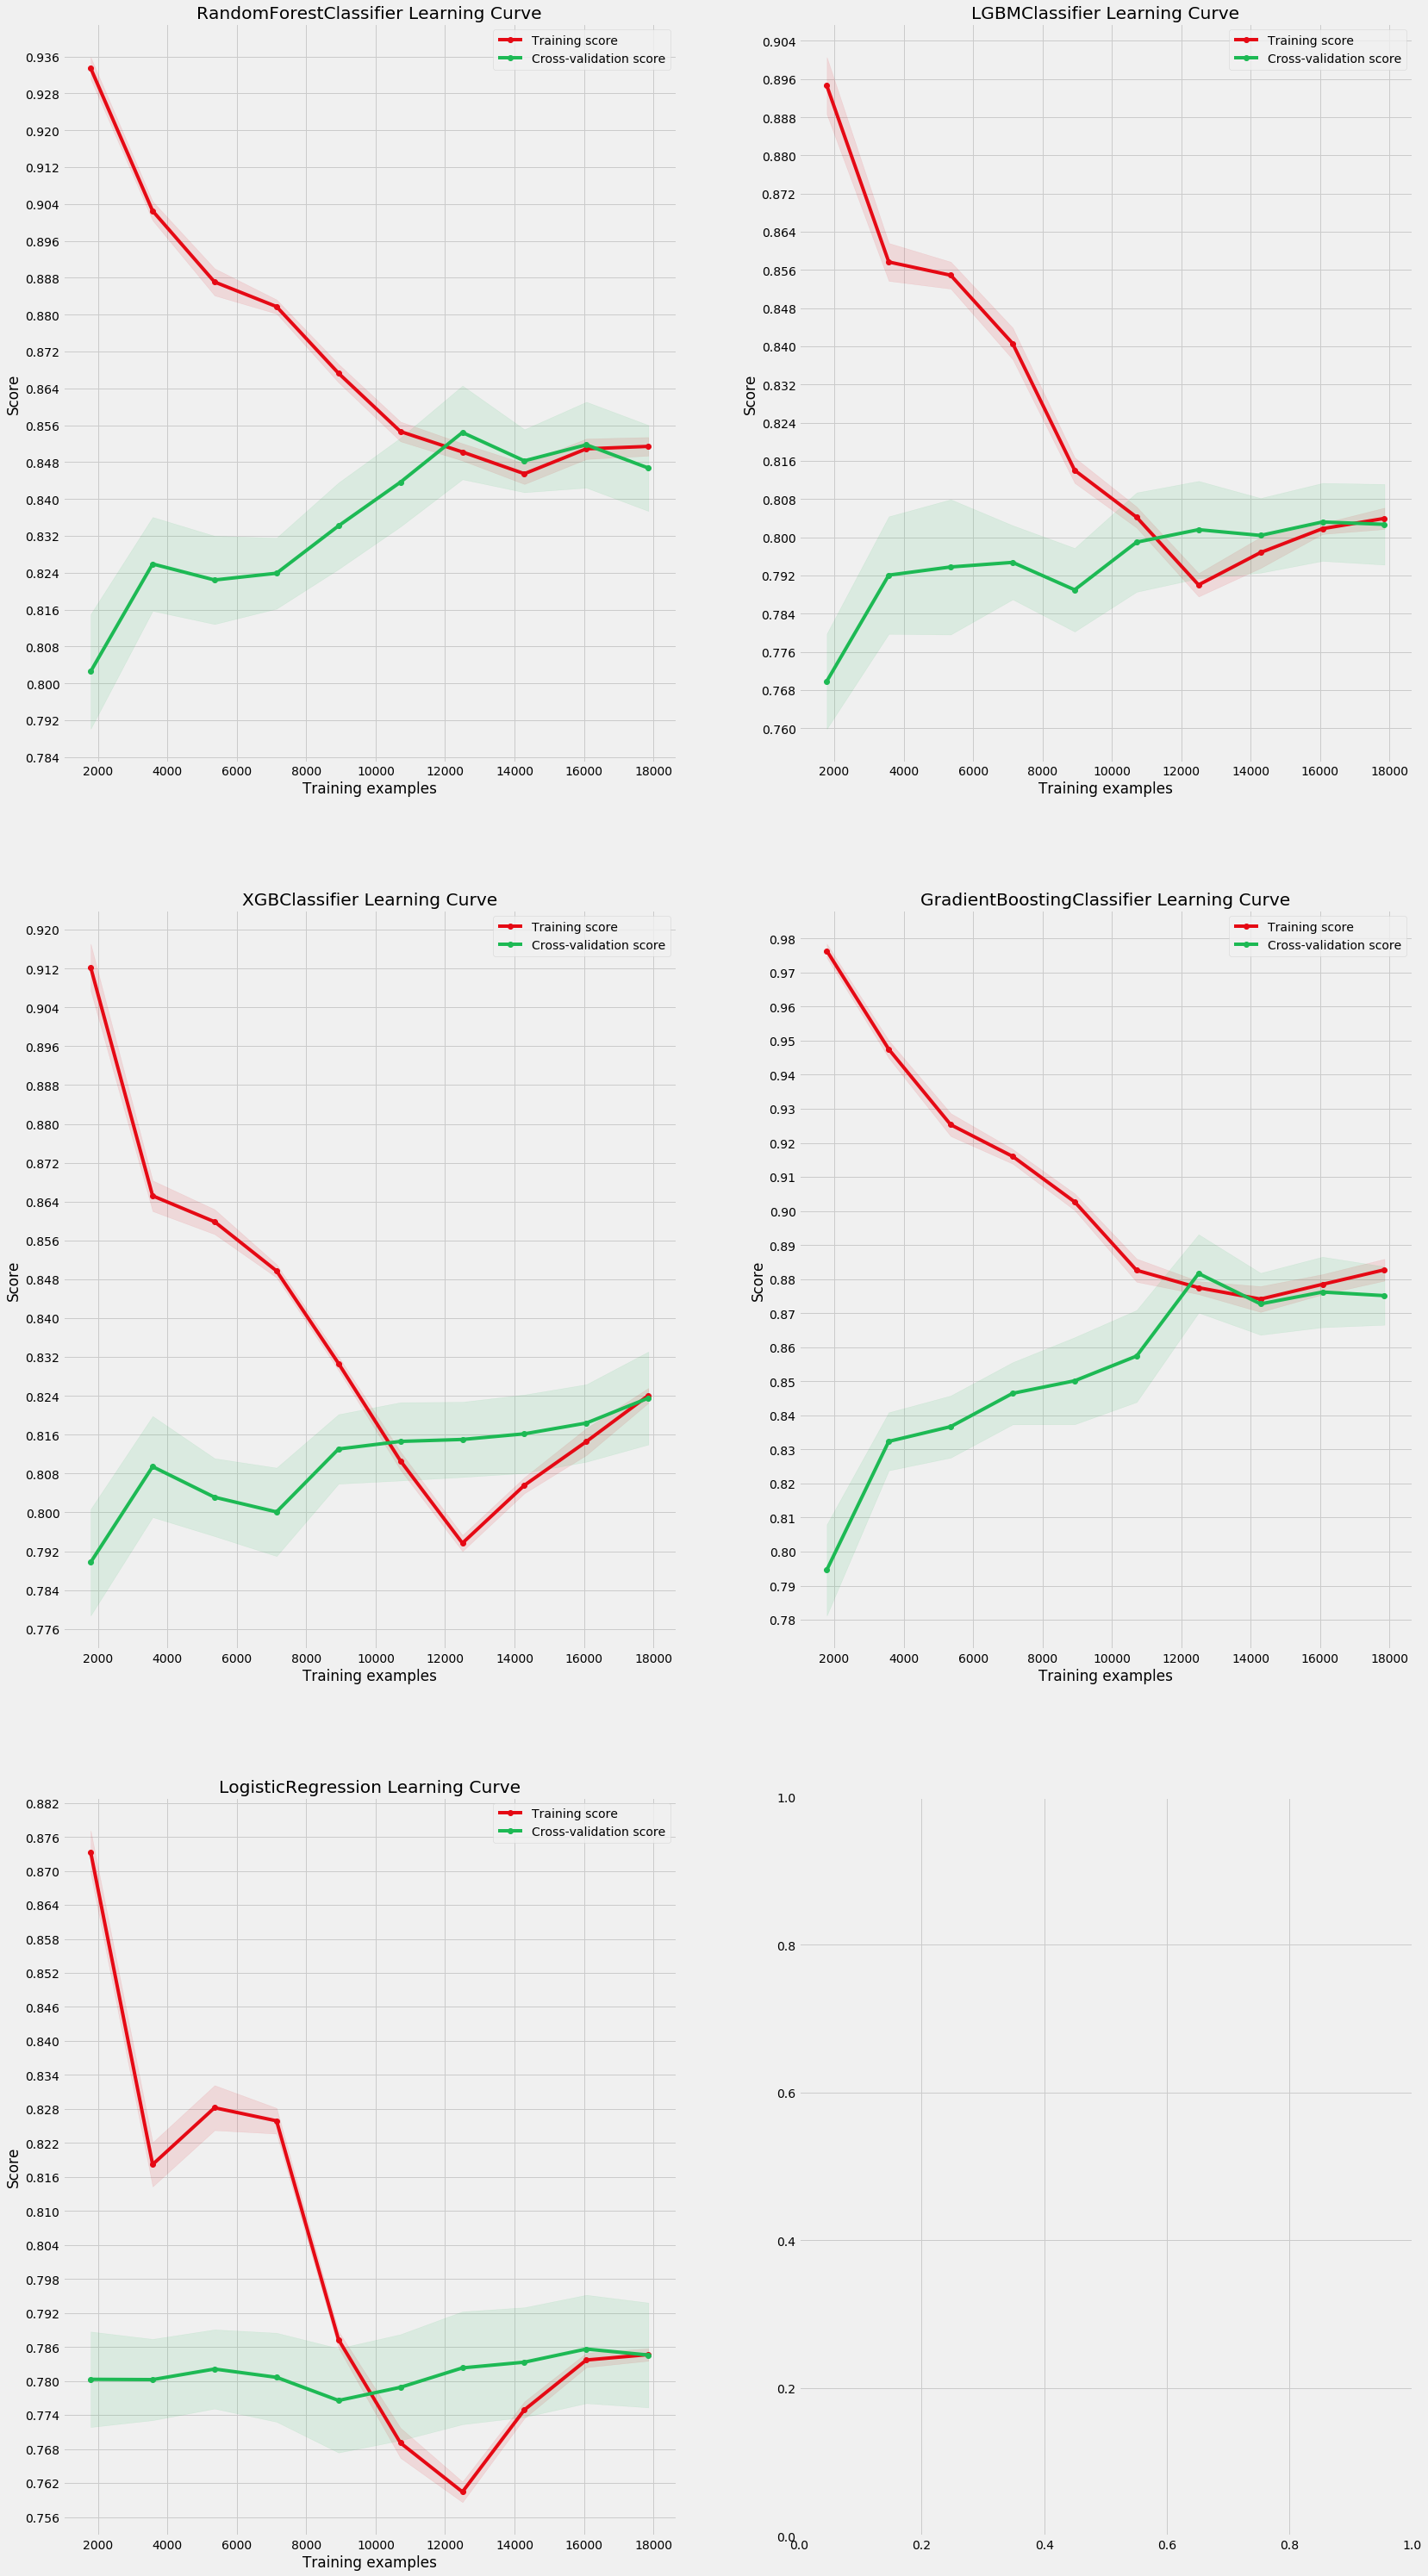

In [27]:
compare_learning_curves(estimators,
                    X,
                    y,
                    cv=cv,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 10))

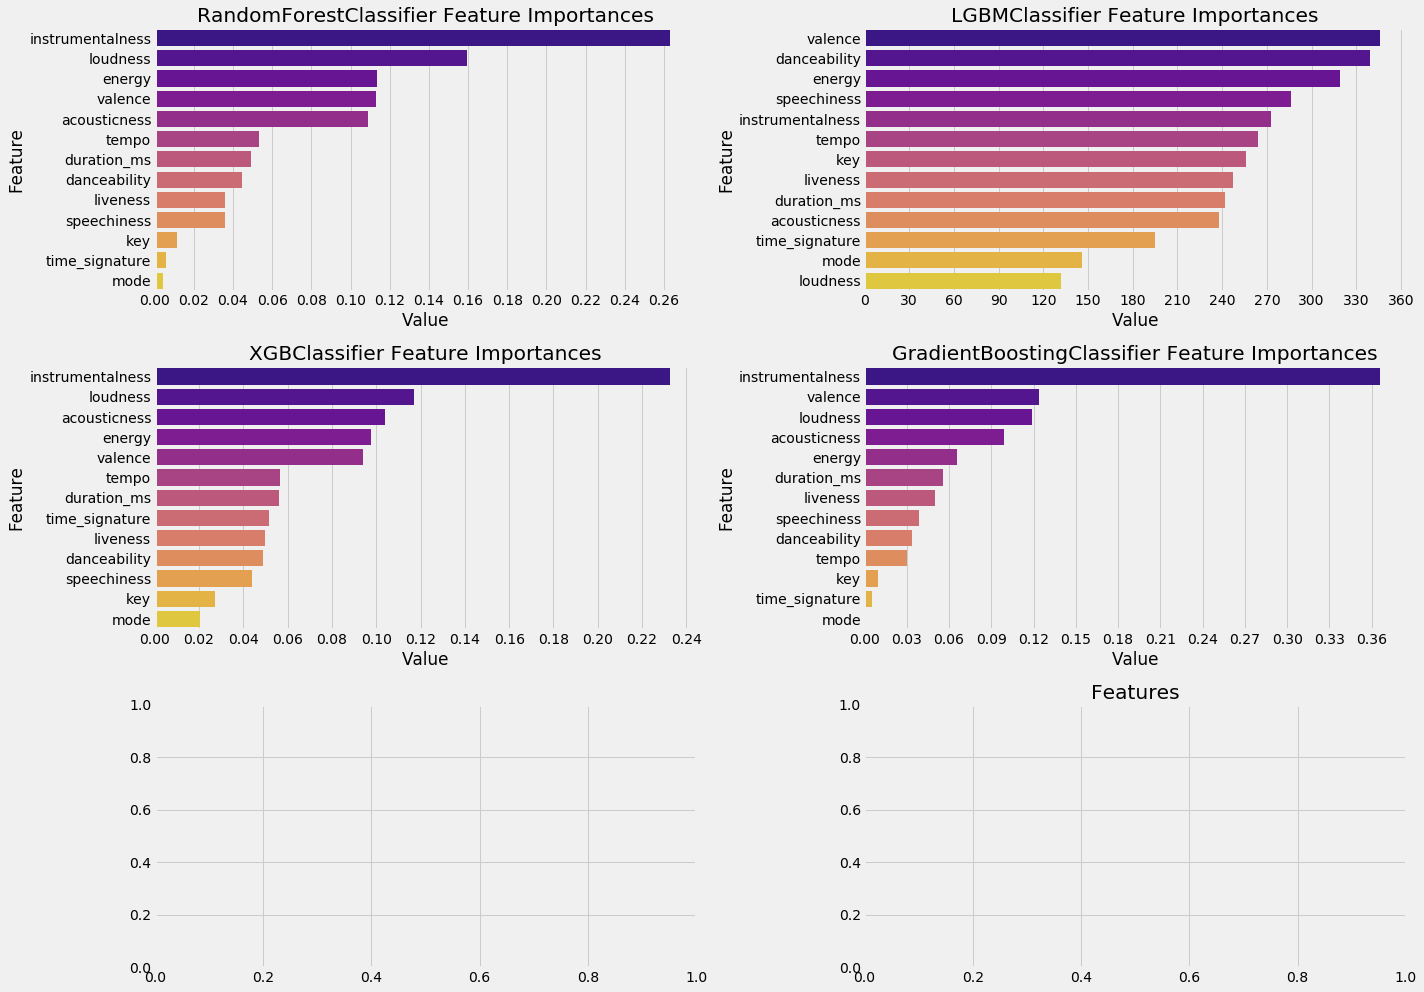

In [29]:
compare_feature_importance(estimators, X, y, 14)

In [27]:
rand_model_full_data = gb.fit(X, y)
print(accuracy_score(y, rand_model_full_data.predict(X)))
y_pred = rand_model_full_data.predict(X_test)

0.8815020161290322


***

So far, we have worked with a small test set.